In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install torchaudio scikit-learn matplotlib


# Required Libraries

In [23]:
import torchaudio
import torchaudio.transforms as transforms
import numpy as np
import os
from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity  
import seaborn as sns

# Load dataset

In [56]:
train_folder = '/kaggle/input/audio-train-1'
test_folder = '/kaggle/input/audio-test-1'

train_files = sorted(os.listdir(train_folder))
test_files = sorted(os.listdir(test_folder))

# Signal Waveform Visualization

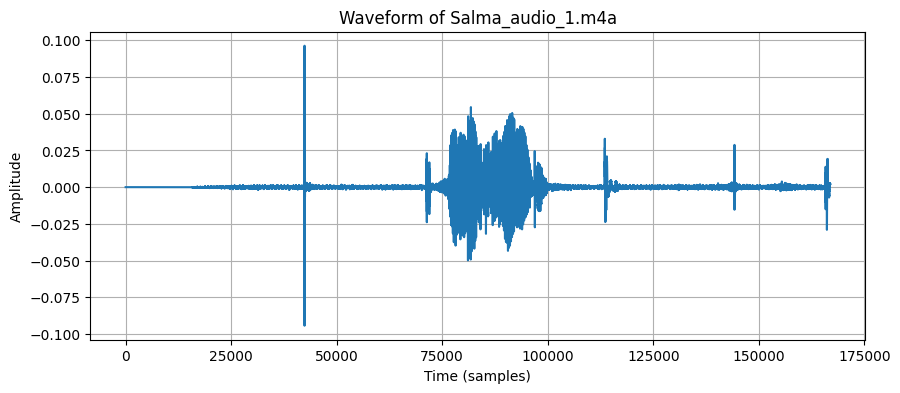

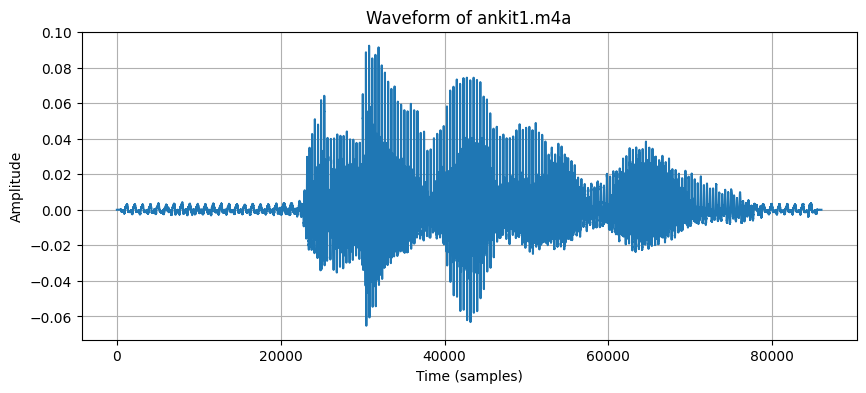

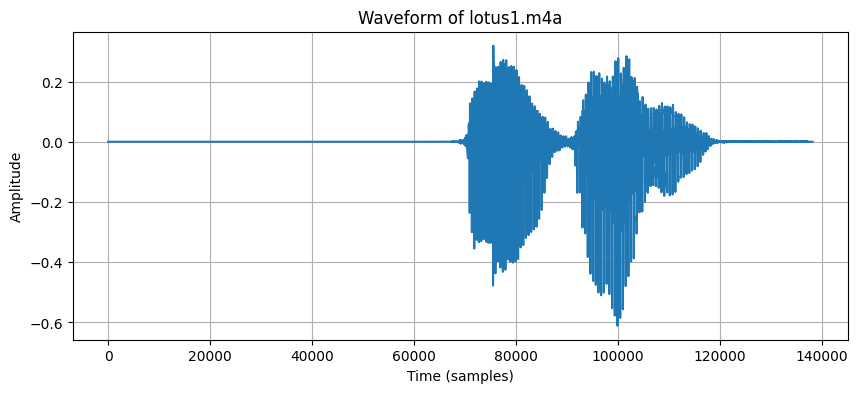

In [88]:
def plot_waveform(audio_file):
    waveform, sample_rate = torchaudio.load(audio_file)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    
    plt.figure(figsize=(10, 4))
    plt.plot(waveform.t().numpy())
    plt.title(f'Waveform of {os.path.basename(audio_file)}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

audio_file = os.path.join(train_folder, 'Salma_audio_1.m4a')
plot_waveform(audio_file)

audio_file = os.path.join(train_folder, 'ankit1.m4a')
plot_waveform(audio_file)

audio_file = os.path.join(train_folder, 'lotus1.m4a')
plot_waveform(audio_file)

# MFCC extraction

In [52]:
def extract_mfcc(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    mfcc_transform = transforms.MFCC(sample_rate=sample_rate, n_mfcc=40)
    mfcc = mfcc_transform(waveform)
    return mfcc.mean(dim=2).squeeze().numpy()

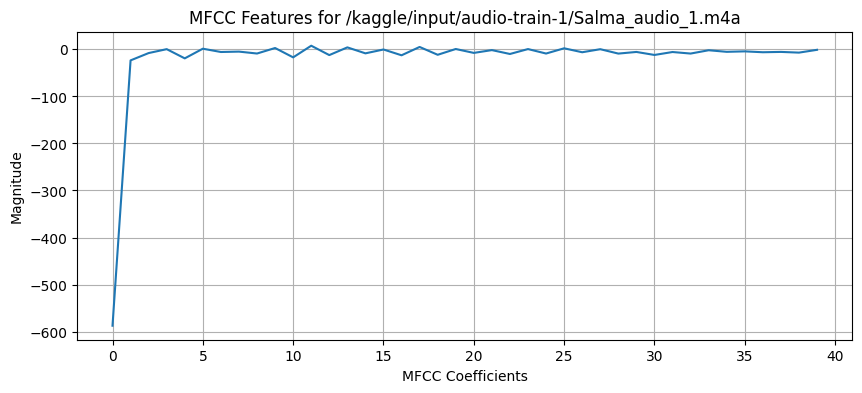

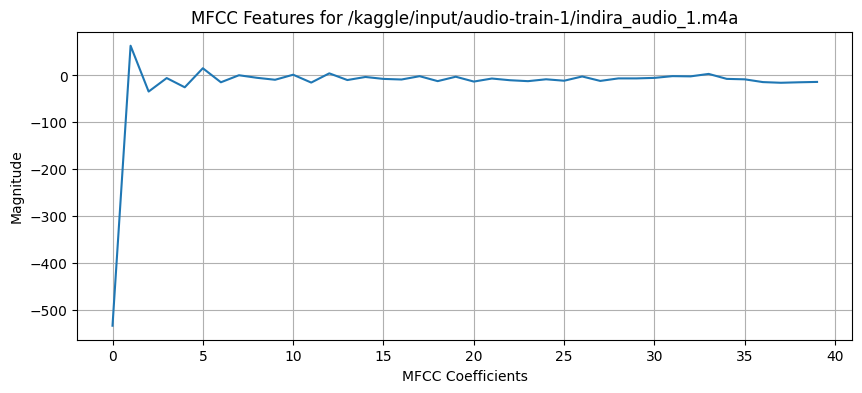

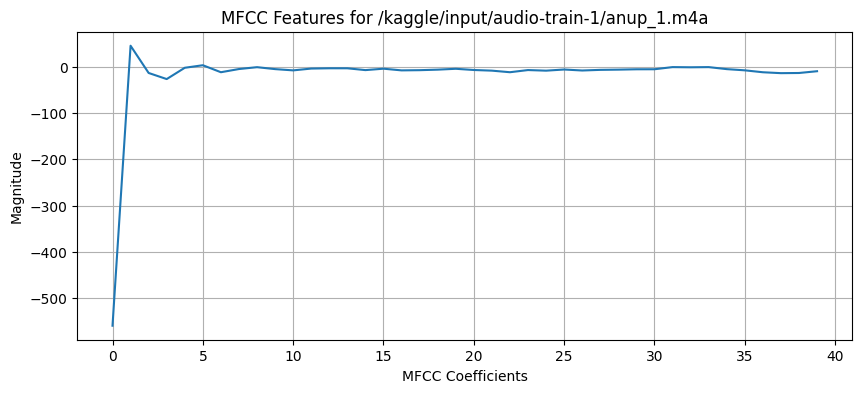

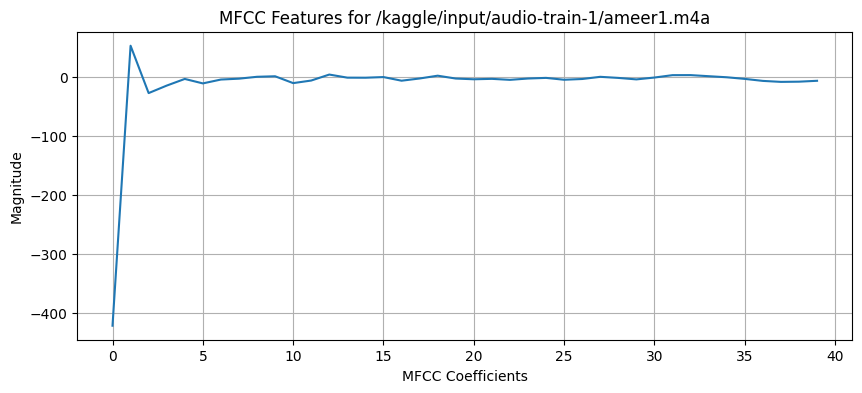

In [89]:
def plot_mfcc(audio_file):
    mfcc = extract_mfcc(audio_file)
    
    plt.figure(figsize=(10, 4))
    plt.plot(mfcc)
    plt.title(f'MFCC Features for {audio_file}')
    plt.xlabel('MFCC Coefficients')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

train_folder = '/kaggle/input/audio-train-1'
audio_file = os.path.join(train_folder, 'Salma_audio_1.m4a')  
plot_mfcc(audio_file)

audio_file = os.path.join(train_folder, 'indira_audio_1.m4a')  
plot_mfcc(audio_file)

audio_file = os.path.join(train_folder, 'anup_1.m4a')  
plot_mfcc(audio_file)

audio_file = os.path.join(train_folder, 'ameer1.m4a')  
plot_mfcc(audio_file)

# Dataset Preparation

In [55]:
def prepare_dataset(audio_folder, files):
    embeddings = []
    for audio_file in files:
        if audio_file.endswith(".m4a"):
            audio_path = os.path.join(audio_folder, audio_file)
            feature = extract_mfcc(audio_path)
            embeddings.append(feature)
    return np.array(embeddings)

train_embeddings = prepare_dataset(train_folder, train_files)
test_embeddings = prepare_dataset(test_folder, test_files)

# PCA

In [79]:
def apply_pca(embeddings, n_components=8):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(embeddings)

train_embeddings_pca = apply_pca(train_embeddings)
test_embeddings_pca = apply_pca(test_embeddings)

print(train_embeddings_pca.shape)
print(test_embeddings_pca.shape)

(8, 8)
(8, 8)


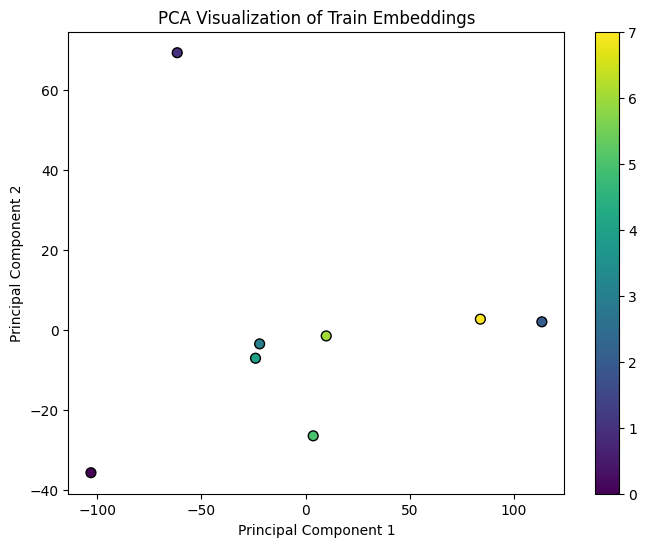

In [81]:
plt.figure(figsize=(8, 6))
plt.scatter(train_embeddings_pca[:, 0], train_embeddings_pca[:, 1], c=train_labels, cmap='viridis', edgecolor='k', s=50)
plt.colorbar()
plt.title("PCA Visualization of Train Embeddings")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Cosine Similarity

In [82]:
def compute_cosine_similarity(train_embeddings, test_embeddings):
    return cosine_similarity(test_embeddings, train_embeddings)

similarity_matrix = compute_cosine_similarity(train_embeddings_pca, test_embeddings_pca)
print("\nMost Similar Train File for Each Test File:")
for test_idx, test_file in enumerate(test_files):
    most_similar_train_idx = np.argmax(similarity_matrix[test_idx])
    similarity_score = similarity_matrix[test_idx, most_similar_train_idx]
    print(f"{test_file} is most similar to {train_files[most_similar_train_idx]} with similarity = {similarity_score:.2f}")


Most Similar Train File for Each Test File:
Bikram2.m4a is most similar to Bikram1.m4a with similarity = 0.98
Salma_audio_2.m4a is most similar to Salma_audio_1.m4a with similarity = 0.92
ameer2.m4a is most similar to ameer1.m4a with similarity = 0.95
ankit2.m4a is most similar to ankit1.m4a with similarity = 0.82
anup_2.m4a is most similar to Salma_audio_1.m4a with similarity = 0.77
indira_audio_2.m4a is most similar to indira_audio_1.m4a with similarity = 0.96
lotus2.m4a is most similar to sumit_sample1.m4a with similarity = 0.82
sumit_sample2.m4a is most similar to sumit_sample1.m4a with similarity = 0.93


# Heatmap

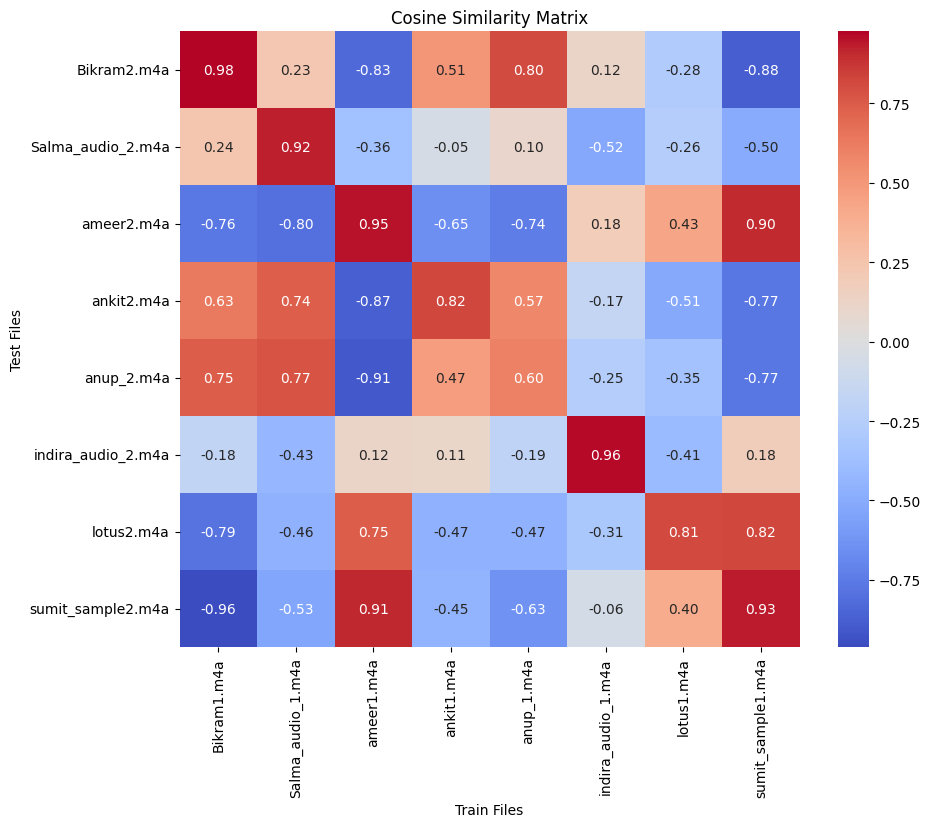

In [83]:
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=train_files, yticklabels=test_files)

plt.title("Cosine Similarity Matrix")
plt.xlabel("Train Files")
plt.ylabel("Test Files")

plt.show()

# KNN classifier

In [65]:
def train_knn(train_embeddings, train_labels):
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(train_embeddings, train_labels)
    return knn

knn = train_knn(train_embeddings_pca, train_labels)

# Accuracy

In [67]:
def predict(knn, test_embeddings_pca):
    return knn.predict(test_embeddings_pca)

test_predictions = predict(knn, test_embeddings_pca)
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 100.00%


# KNN Predictions

In [92]:
for test_idx, test_file in enumerate(test_files):
    predicted_label = knn.predict(test_embeddings_pca[test_idx].reshape(1, -1))[0]
    most_similar_train_idx = np.argmax(similarity_matrix[:, test_idx])
    similarity_score = similarity_matrix[most_similar_train_idx, test_idx]
    
    print(f"{test_file} predicted as {train_files[predicted_label]}")


Bikram2.m4a predicted as Bikram1.m4a
Salma_audio_2.m4a predicted as Salma_audio_1.m4a
ameer2.m4a predicted as ameer1.m4a
ankit2.m4a predicted as ankit1.m4a
anup_2.m4a predicted as anup_1.m4a
indira_audio_2.m4a predicted as indira_audio_1.m4a
lotus2.m4a predicted as lotus1.m4a
sumit_sample2.m4a predicted as sumit_sample1.m4a


# Knn classification visualization

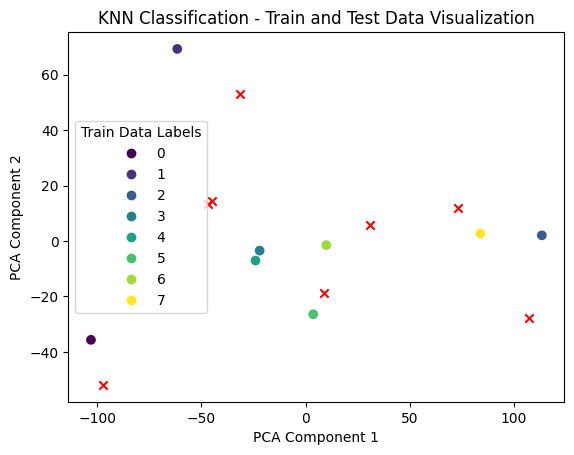

In [93]:
scatter = plt.scatter(train_embeddings_pca[:, 0], train_embeddings_pca[:, 1], c=train_labels, cmap='viridis', label='Train Data')

for i, label in enumerate(test_predictions):
    plt.scatter(test_embeddings_pca[i, 0], test_embeddings_pca[i, 1], c='red', marker='x', label='Test Data' if i == 0 else "")

plt.legend(*scatter.legend_elements(), title="Train Data Labels")
plt.title("KNN Classification - Train and Test Data Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()